25
25
25
25
25
25
25
25
25
25
25
25


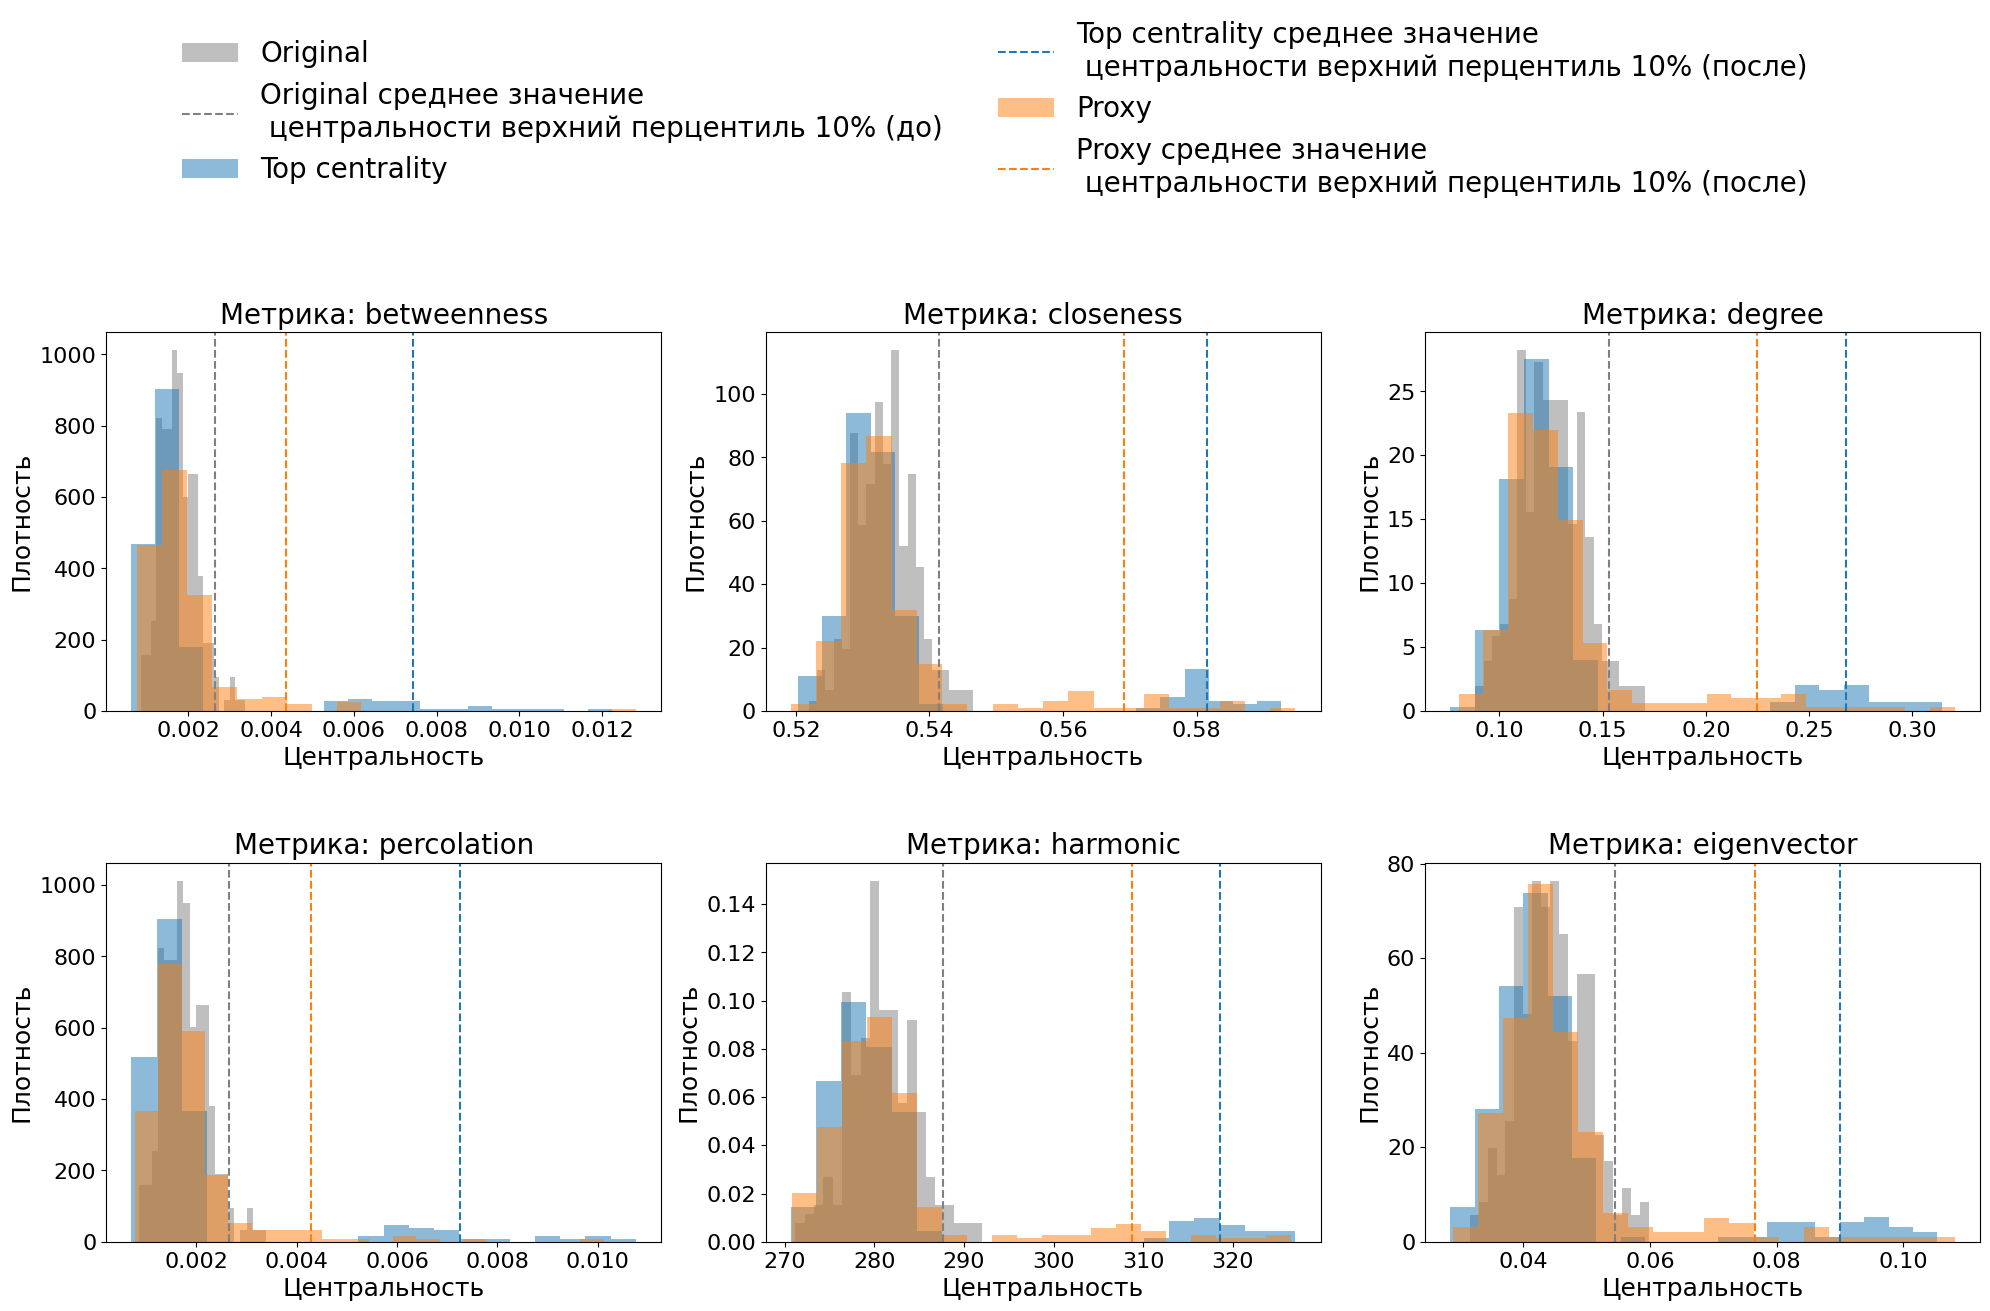

In [5]:
import os
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from typing import List, Tuple

# ---------------- Параметры эксперимента ----------------

n = 500
cluster_sizes = [250, 250]
p_intra = 0.15
p_inter = 0.1
target_cluster_index = 0
proportion_high_centrality = 0.1

centralities = [
    'betweenness', 'closeness', 'degree',
    'percolation', 'harmonic', 'eigenvector'
]

boost_factors = {
    'degree': 2, 'betweenness': 2, 'closeness': 2,
    'eigenvector': 2, 'percolation': 2, 'harmonic': 2,
    'random': 0
}

modes = [
    ("Top centrality", 'one_cluster_s_boost'),
    ("Proxy", "random_neighbors_s_boost"),
]


# Создаём директории для результатов
os.makedirs('sbm_arb/results', exist_ok=True)


# ---------------- Вспомогательные функции ----------------

def _build_base_sbm(n: int, cluster_sizes: List[int],
                    p_intra: float, p_inter: float) -> Tuple[nx.Graph, List[List[int]]]:
    """
    Генерация случайной сети по модели SBM:
      n — общее число узлов;
      cluster_sizes — список размеров кластеров;
      p_intra, p_inter — вероятности рёбер внутри/между кластерами.
    """
    G = nx.Graph()
    G.add_nodes_from(range(n))
    clusters = []
    current = 0
    rng = np.random.default_rng()

    # Разбиение узлов по кластерам
    for sz in cluster_sizes:
        clusters.append(list(range(current, current + sz)))
        current += sz

    # Добавление внутрекластерных рёбер
    for C in clusters:
        for i in C:
            for j in C:
                if j > i and rng.random() < p_intra:
                    G.add_edge(i, j)

    # Добавление межкластерных рёбер
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            for u in clusters[i]:
                for v in clusters[j]:
                    if rng.random() < p_inter:
                        G.add_edge(u, v)

    return G, clusters


def enforce_target_connectivity(G: nx.Graph,
                                cluster_sizes: List[int],
                                p_intra: float, p_inter: float) -> nx.Graph:
    """
    Если в модифицированном графе число внутр./межкластерных рёбер превысило
    целевое, удаляем случайные «лишние» рёбра до нужного количества.
    """
    # Общее число возможных внутр. и меж. рёбер
    intra_possible = sum(sz*(sz-1)//2 for sz in cluster_sizes)
    inter_possible = sum(cluster_sizes[i] * cluster_sizes[j]
                         for i in range(len(cluster_sizes))
                         for j in range(i+1, len(cluster_sizes)))
    target_intra = round(p_intra * intra_possible)
    target_inter = round(p_inter * inter_possible)

    # Определяем, какие рёбра intra, а какие inter
    labels = np.empty(G.number_of_nodes(), dtype=int)
    idx = 0
    for cid, sz in enumerate(cluster_sizes):
        labels[idx:idx+sz] = cid
        idx += sz

    intra_edges, inter_edges = [], []
    for u, v in G.edges():
        if labels[u] == labels[v]:
            intra_edges.append((u, v))
        else:
            inter_edges.append((u, v))

    # Убираем лишние внутр. рёбра
    if len(intra_edges) > target_intra:
        to_remove = np.random.default_rng().choice(
            intra_edges,
            size=len(intra_edges) - target_intra,
            replace=False
        )
        G.remove_edges_from(to_remove)

    # Убираем лишние меж. рёбра
    if len(inter_edges) > target_inter:
        to_remove = np.random.default_rng().choice(
            inter_edges,
            size=len(inter_edges) - target_inter,
            replace=False
        )
        G.remove_edges_from(to_remove)

    return G


def minmax_normalize(d: dict) -> dict:
    """
    Мин–макс нормализация значений словаря.
    """
    vals = np.array(list(d.values()), dtype=float)
    lo, hi = vals.min(), vals.max()
    if hi - lo < 1e-12:
        return {k: 0.0 for k in d}
    return {k: (v - lo) / (hi - lo) for k, v in d.items()}


def get_centrality(G: nx.Graph, clusters: List[List[int]],
                   ctype: str, norm: bool, cluster_type: str) -> dict:
    """
    Вычисление центральности:
      ctype ∈ {'degree','betweenness','eigenvector',
               'percolation','closeness','harmonic','random'}.
      norm — выполнять мин–макс нормализацию.
      cluster_type = 'cluster12' для random по всему графу.
    """
    if ctype == "degree":
        cent = nx.degree_centrality(G)
    elif ctype == "betweenness":
        cent = nx.betweenness_centrality(G)
    elif ctype == "eigenvector":
        cent = nx.eigenvector_centrality(G, max_iter=1000)
    elif ctype == "percolation":
        cent = nx.percolation_centrality(G)
    elif ctype == "closeness":
        cent = nx.closeness_centrality(G)
    elif ctype == "harmonic":
        cent = nx.harmonic_centrality(G)
    elif ctype == "random":
        rng = np.random.default_rng()
        if cluster_type == 'cluster12':
            cent = {u: rng.random() for u in G.nodes()}
        else:
            target = clusters[target_cluster_index]
            cent = {u: rng.random() for u in target}
    else:
        raise ValueError(f"Неподдерживаемый тип центральности: {ctype}")

    return minmax_normalize(cent) if norm else cent


def plot_adjacency_add(G: nx.Graph,
                       added_edges: List[Tuple[int,int]] = None,
                       high_nodes: List[int] = None,
                       title: str = ''):
    """
    Визуализация матрицы смежности:
      — белые пиксели = существующие рёбра;
      — зелёные = добавленные;
      — красные метки на осях = управляющие узлы.
    """
    nodelist = sorted(G.nodes())
    idx = {u:i for i,u in enumerate(nodelist)}
    A = nx.to_numpy_array(G, nodelist=nodelist)
    col = np.zeros((len(nodelist), len(nodelist), 3))
    col[A==1] = [1,1,1]  # все исходные рёбра — белые

    if added_edges:
        for u, v in added_edges:
            i, j = idx[u], idx[v]
            col[i,j] = [0,1,0]
            col[j,i] = [0,1,0]

    plt.figure(figsize=(6,6))
    plt.title(title, loc='left', x=-0.05, fontsize=14)
    plt.imshow(col, interpolation='none')
    plt.xticks(range(len(nodelist)), nodelist, fontsize=10)
    plt.yticks(range(len(nodelist)), nodelist, fontsize=10)

    if high_nodes:
        ax = plt.gca()
        for lbl in ax.get_xticklabels():
            node = int(lbl.get_text())
            if node in high_nodes:
                lbl.set_color('red')
                lbl.set_fontweight('bold')
        for lbl in ax.get_yticklabels():
            node = int(lbl.get_text())
            if node in high_nodes:
                lbl.set_color('red')
                lbl.set_fontweight('bold')

    plt.tight_layout()
    plt.axis('off')


def apply_boost_on_base(
    G_base: nx.Graph,
    clusters: List[List[int]],
    centrality_type: str,
    boost_factor: float,
    mode: str
) -> Tuple[nx.Graph, nx.Graph, List[int]]:
    """
    Отдельная функция «буста», которая берёт:
      — незатронутый G_base,
      — возвращает (G_before, G_after, top_nodes).
    """
    G_before = G_base.copy()
    scores = get_centrality(
        G_before, clusters,
        ctype=centrality_type, norm=False,
        cluster_type='cluster12'
    )

    # Целевой кластер
    C1 = clusters[target_cluster_index]
    C2 = [u for i, cl in enumerate(clusters) if i != target_cluster_index for u in cl]
    k_top = math.ceil(proportion_high_centrality * len(C1))

    # Выбор управляющих узлов
    if mode.startswith('one_cluster'):
        top_nodes = sorted(C1, key=lambda u: scores[u], reverse=True)[:k_top]
    else:
        top3 = sorted(C2, key=lambda u: scores[u], reverse=True)[:3]
        nbrs = {v for u in top3 for v in G_before.neighbors(u) if v in C1}
        cent_list = sorted([(u, scores[u]) for u in nbrs], key=lambda x: x[1], reverse=True)
        if mode.startswith('top_neighbors'):
            top_nodes = [u for u,_ in cent_list[:k_top]]
        else:
            rng = np.random.default_rng()
            candidates = [u for u,_ in cent_list]
            top_nodes = rng.choice(candidates, size=min(k_top,len(candidates)), replace=False).tolist()

    # Применяем буст
    if mode.endswith('bez_boost'):
        G_after = G_before.copy()
    else:
        G_mod = G_before.copy()
        max_score = max((scores[u] for u in top_nodes), default=0.0)
        for u in top_nodes:
            neighbors_count = sum(1 for v in G_mod.nodes() if G_mod.has_edge(u, v))
            potential = [v for v in G_mod.nodes() if v != u and not G_mod.has_edge(u, v)]
            if max_score <= 0 or neighbors_count == 0 or not potential:
                continue
            norm_score = scores[u] / max_score
            delta_k = int(math.ceil((boost_factor - 1) * norm_score * neighbors_count))
            if delta_k <= 0:
                continue
            chosen = np.random.default_rng().choice(
                potential, size=min(delta_k, len(potential)), replace=False
            )
            G_mod.add_edges_from((u, v) for v in chosen)
        G_after = enforce_target_connectivity(G_mod, cluster_sizes, p_intra, p_inter)

    return G_before, G_after, top_nodes


def circular_cluster_layout(clusters, centers, cluster_radius=1):
    """
    Размещение узлов кластеров по окружностям вокруг центров.
    """
    pos = {}
    for idx, cluster in enumerate(clusters):
        cx, cy = centers[idx]
        angles = np.linspace(0, 2*np.pi, len(cluster), endpoint=False)
        for u, angle in zip(cluster, angles):
            pos[u] = (cx + cluster_radius * np.cos(angle),
                      cy + cluster_radius * np.sin(angle))
    return pos


def plot_graph(G, pos, title, node_colors, high_nodes=None, added_edges=None):
    """
    Визуализация графа:
      — красные узлы = управляющие;
      — зелёные рёбра = добавленные.
    """
    plt.figure(figsize=(7,7))
    nx.draw_networkx_nodes(
        G, pos,
        node_color=[node_colors[u] for u in G.nodes()],
        node_size=400
    )
    if high_nodes is not None:
        nx.draw_networkx_nodes(
            G, pos,
            nodelist=high_nodes,
            node_color='red',
            node_size=400
        )
    nx.draw_networkx_edges(G, pos, alpha=0.4)
    if added_edges:
        nx.draw_networkx_edges(
            G, pos,
            edgelist=added_edges,
            edge_color='green',
            width=2
        )
    nx.draw_networkx_labels(G, pos, font_size=12)
    plt.title(title, fontsize=16, loc='left')
    plt.axis('off')
    plt.tight_layout()


# ---------------- ОСНОВНОЙ СКРИПТ ----------------

# 1) Сгенерируем одну базовую сеть SBM
G_base, clusters = _build_base_sbm(n, cluster_sizes, p_intra, p_inter)
target_cluster = clusters[target_cluster_index]

# 2) Подготовим холст для гистограмм
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
axs = axs.flatten()

# 3) Основной цикл по метрикам центральности
for i, cent in enumerate(centralities):
    # 3.1) Центральность на исходной сети
    orig_c = get_centrality(
        G_base, clusters,
        ctype=cent, norm=False,
        cluster_type='cluster12'
    )
    k_top = math.ceil(proportion_high_centrality * len(target_cluster))
    orig_high = sorted(target_cluster, key=lambda u: orig_c[u], reverse=True)[:k_top]

    hist_data  = {"Original": [orig_c[u] for u in target_cluster]}
    high_nodes = {"Original": orig_high}
    c_mod_dict = {"Original": orig_c}

    # 3.2) Применяем буст для каждого режима
    for label, mode in modes:
        G_orig, G_mod, high = apply_boost_on_base(
            G_base, clusters,
            centrality_type=cent,
            boost_factor=boost_factors.get(cent, 2),
            mode=mode
        )
        print(len(high))
        c_mod = get_centrality(
            G_mod, clusters,
            ctype=cent, norm=False,
            cluster_type='cluster12'
        )
        hist_data[label]  = [c_mod[u] for u in target_cluster]
        high_nodes[label] = high
        c_mod_dict[label] = c_mod

        # 3.2.1) Сохраняем матрицу смежности до/после
        added = list(set(G_mod.edges()) - set(G_orig.edges()))

        plot_adjacency_add(
            G_orig, added_edges=None, high_nodes=None,
            title=f"{cent} — {label} (orig adj)"
        )
        plt.savefig(f"sbm_arb/results/adj_{cent}_{mode}_orig.png")
        plt.close()

        plot_adjacency_add(
            G_mod, added_edges=added, high_nodes=high,
            title=f"{cent} — {label} (mod adj)"
        )
        plt.savefig(f"sbm_arb/results/adj_{cent}_{mode}_mod.png")
        plt.close()

        # 3.2.2) Сохраняем граф до/после
        centers = [(-3, 0), (3, 0)]
        pos = circular_cluster_layout(clusters, centers, cluster_radius=2)

        # оригинальный граф
        plot_graph(
            G_orig, pos,
            title=f"{cent} — {label} (orig graph)",
            node_colors={u: ('skyblue' if u in clusters[0] else 'lightgreen')
                         for u in G_orig.nodes()},
            high_nodes=None,
            added_edges=None
        )
        plt.savefig(f"sbm_arb/results/graph_{cent}_{mode}_orig.png")
        plt.close()

        # модифицированный граф
        plot_graph(
            G_mod, pos,
            title=f"{cent} — {label} (mod graph)",
            node_colors={u: ('skyblue' if u in clusters[0] else 'lightgreen')
                         for u in G_mod.nodes()},
            high_nodes=high,
            added_edges=added
        )
        plt.savefig(f"sbm_arb/results/graph_{cent}_{mode}_mod.png")
        plt.close()

    # 3.3) Строим гистограмму распределений
    ax = axs[i]
    colors = ["gray", "C0", "C1", "C2"]
    labels_all = ["Original"] + [lbl for lbl, _ in modes]
    for lbl, color in zip(labels_all, colors):
        ax.hist(
            hist_data[lbl],
            bins=20, density=True, alpha=0.5,
            label=lbl, color=color
        )
        vals_high = [c_mod_dict[lbl][u] for u in high_nodes[lbl]]
        suffix = '(до)' if lbl == 'Original' else '(после)'
        ax.axvline(
            np.mean(vals_high),
            linestyle='--',
            label=f"{lbl} среднее значение \n центральности верхний перцентиль {int(100*proportion_high_centrality)}% {suffix}",
            color=color
        )
    ax.set_title(f"Метрика: {cent}", fontsize=20)
    ax.set_xlabel("Центральность", fontsize=18)
    ax.set_ylabel("Плотность", fontsize=18)
    ax.tick_params(labelsize=16)

handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(
    handles, labels,
    loc='upper center',
    ncol=2,
    fontsize=20,         # увеличенный размер шрифта
    markerscale=1.5,      # увеличенный размер маркеров
    handlelength=2,       # более длинные линии в легенде
    frameon=False,
    bbox_to_anchor=(0.5, 1.10)  # чуть выше
)


# 5) Финальная подстройка отступов
plt.tight_layout()
plt.subplots_adjust(top=0.82, hspace=0.4)  # добавили hspace для увеличения расстояния между рядами
fig.savefig(
    'sbm_arb/6_centrality_distributions.svg',
    format='svg',
    bbox_inches='tight',
    bbox_extra_artists=[lgd],
)
plt.show()

In [2]:
handles, labels = axs[-1].get_legend_handles_labels()

# 2) рисуем легенду и сохраняем её объект
lgd = fig.legend(
    handles,
    labels,
    loc='lower center',          # по центру снизу
    bbox_to_anchor=(0.5, -0.25), # смещение вниз
    ncol=1,                      # вертикальный список
    fontsize=16,
    frameon=False
)

# 3) резервируем место снизу
fig.subplots_adjust(
    hspace=0.5,   # расстояние между рядами
    bottom=0.1   # резервирование места под легенду
)
# 4) сохраняем в SVG с учётом легенды
fig.savefig(
    'sbm_arb/6_centrality_distributions.svg',
    format='svg',
    bbox_inches='tight',
    bbox_extra_artists=[lgd],
)

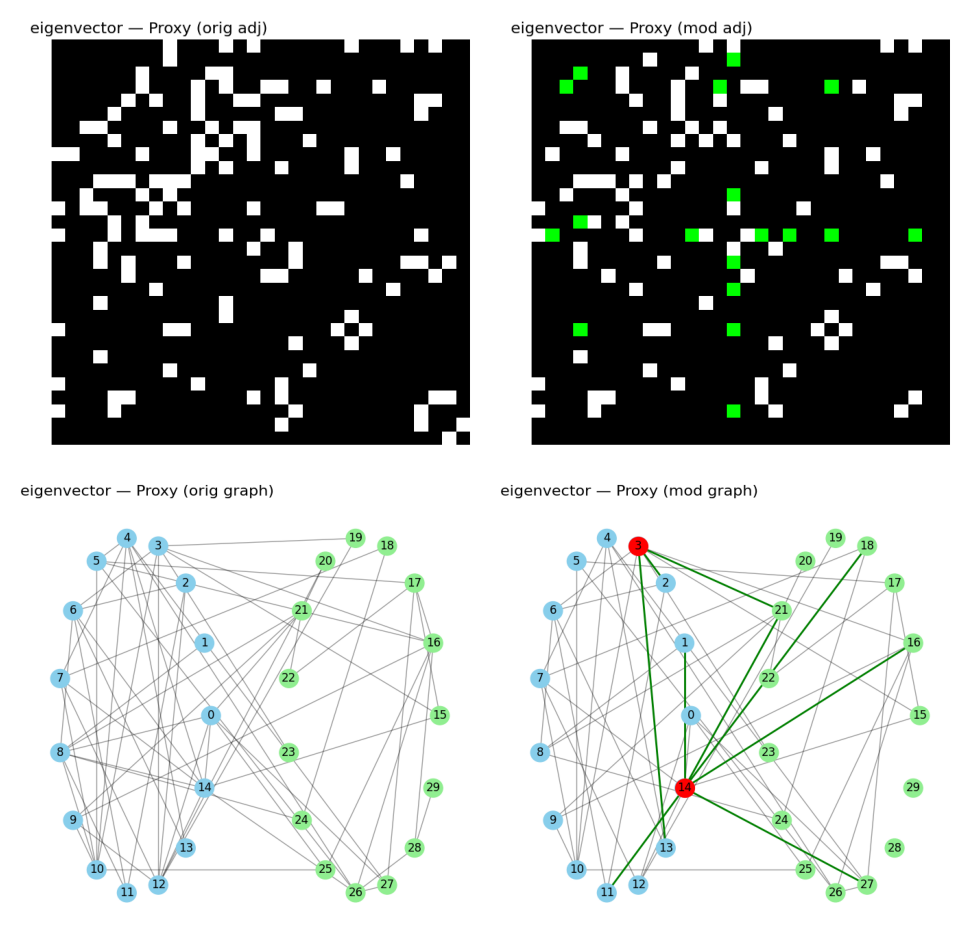

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Настройки для максимально плотной компоновки
plt.rcParams['figure.autolayout'] = False  # Отключаем авто-лейаут

# Создаем фигуру с 2 рядами и 3 столбцами
fig, axes = plt.subplots(2, 2, figsize=(10, 10), 
                        gridspec_kw={'wspace': 0, 'hspace': 0})

# Полностью убираем все отступы и промежутки
plt.subplots_adjust(left=0.02, right=0.98, 
                    bottom=0.02, top=0.95,
                    wspace=0, hspace=0)

for i, cent in enumerate(centralities):
    for label, mode in modes:
        for row_idx in range(2):
            for col_idx in range(2):
                ax = axes[row_idx, col_idx]
                
                # Загрузка изображений (замените пути)
                if row_idx == 0:
                    img = mpimg.imread(f'sbm_arb/results/adj_{cent}_{mode}_{["orig", "mod"][col_idx]}.png')
                else:
                    img = mpimg.imread(f'sbm_arb/results/graph_{cent}_{mode}_{["orig", "mod"][col_idx]}.png')
                    
                # Отображение с заполнением всего subplot
                ax.imshow(img, aspect='auto')
                ax.axis('off')

        # Сохраняем с минимальными отступами
        plt.savefig(f'sbm_arb/results/combined_plot_{cent}_{mode}.png', 
                   bbox_inches='tight', 
                   pad_inches=0.02, 
                   dpi=300)

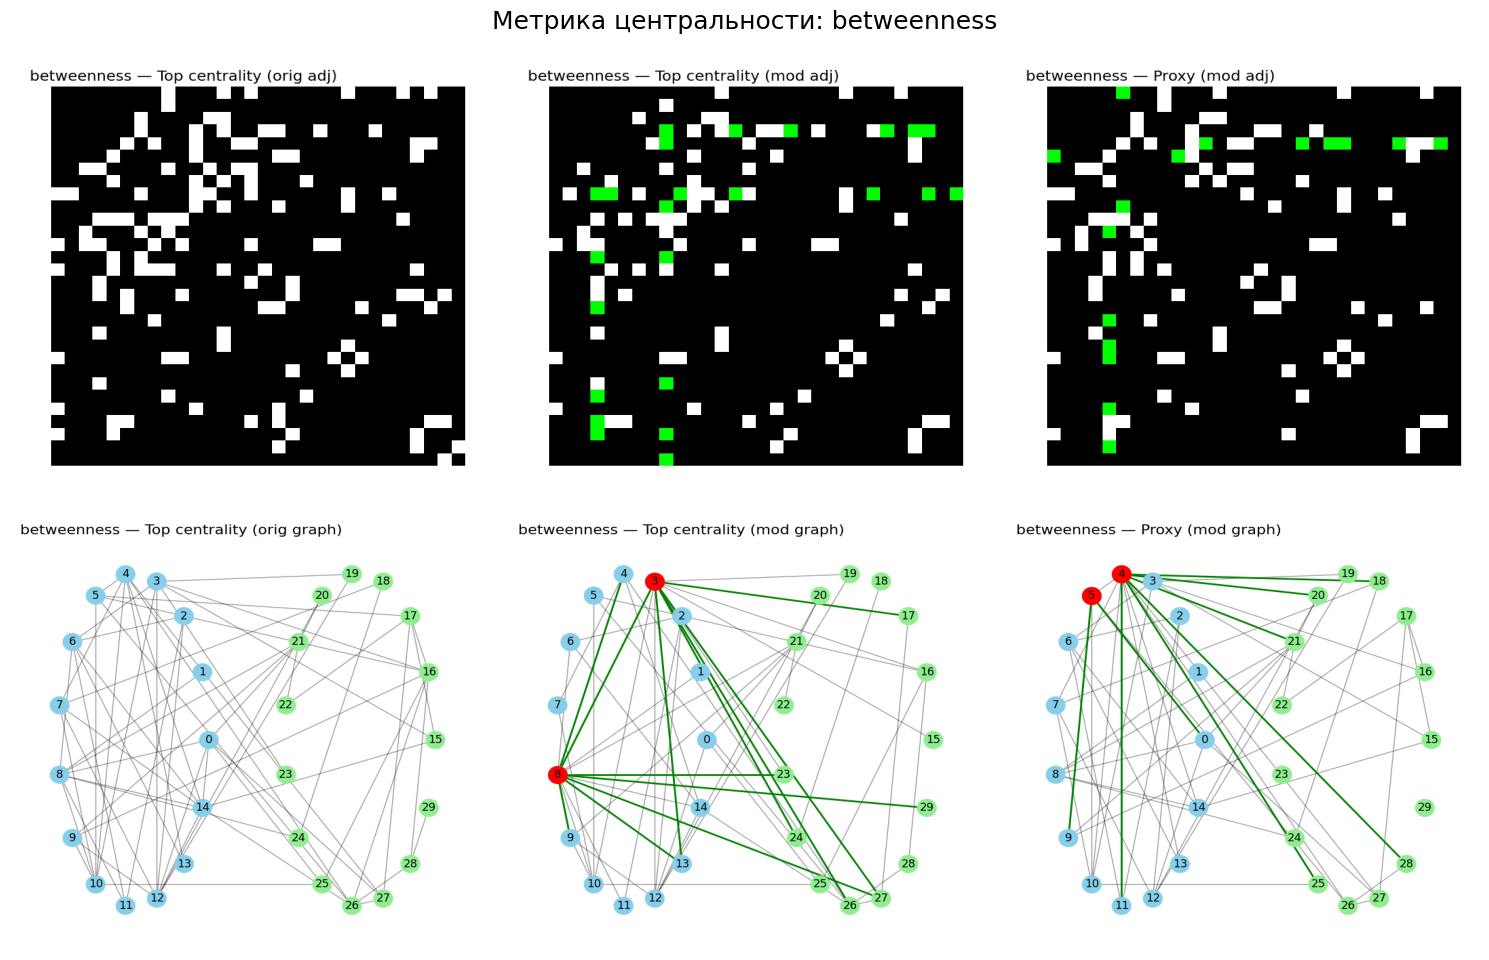

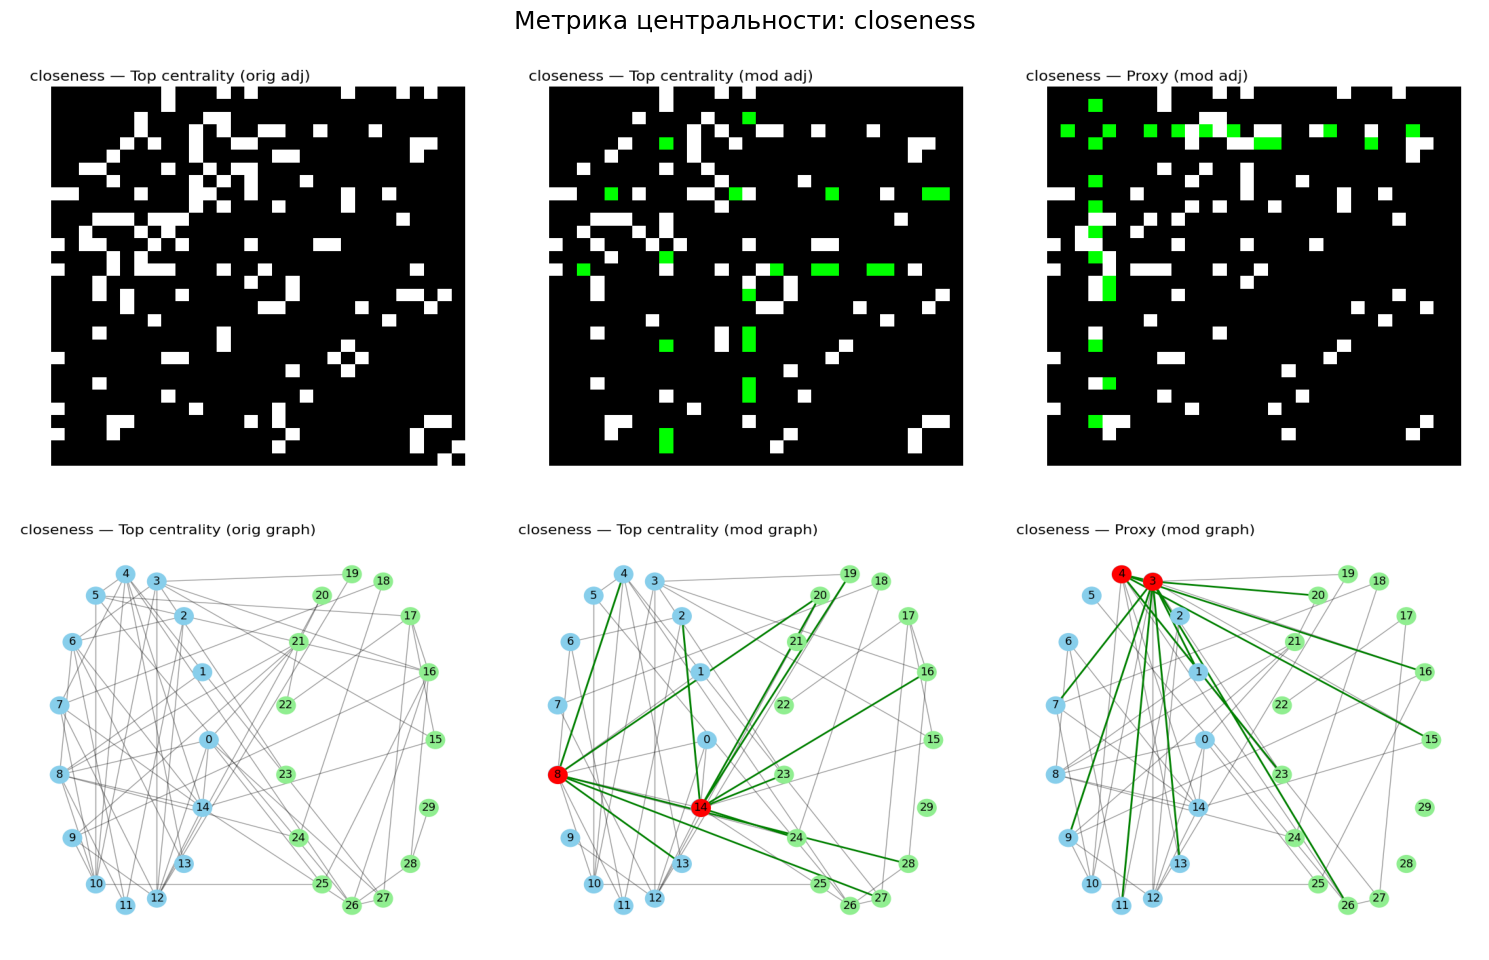

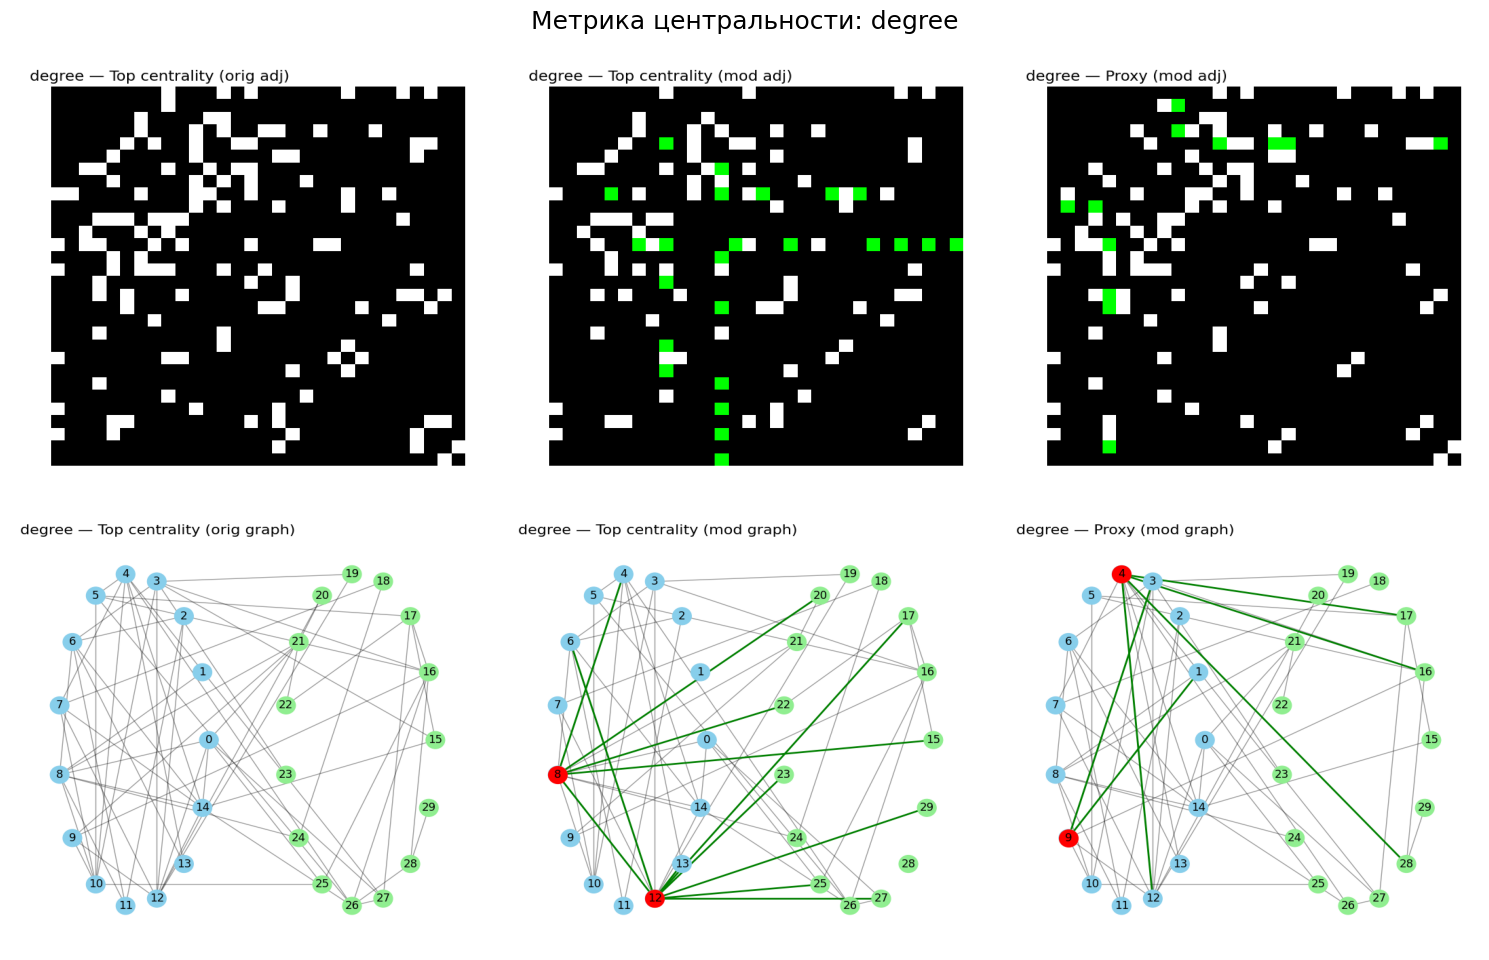

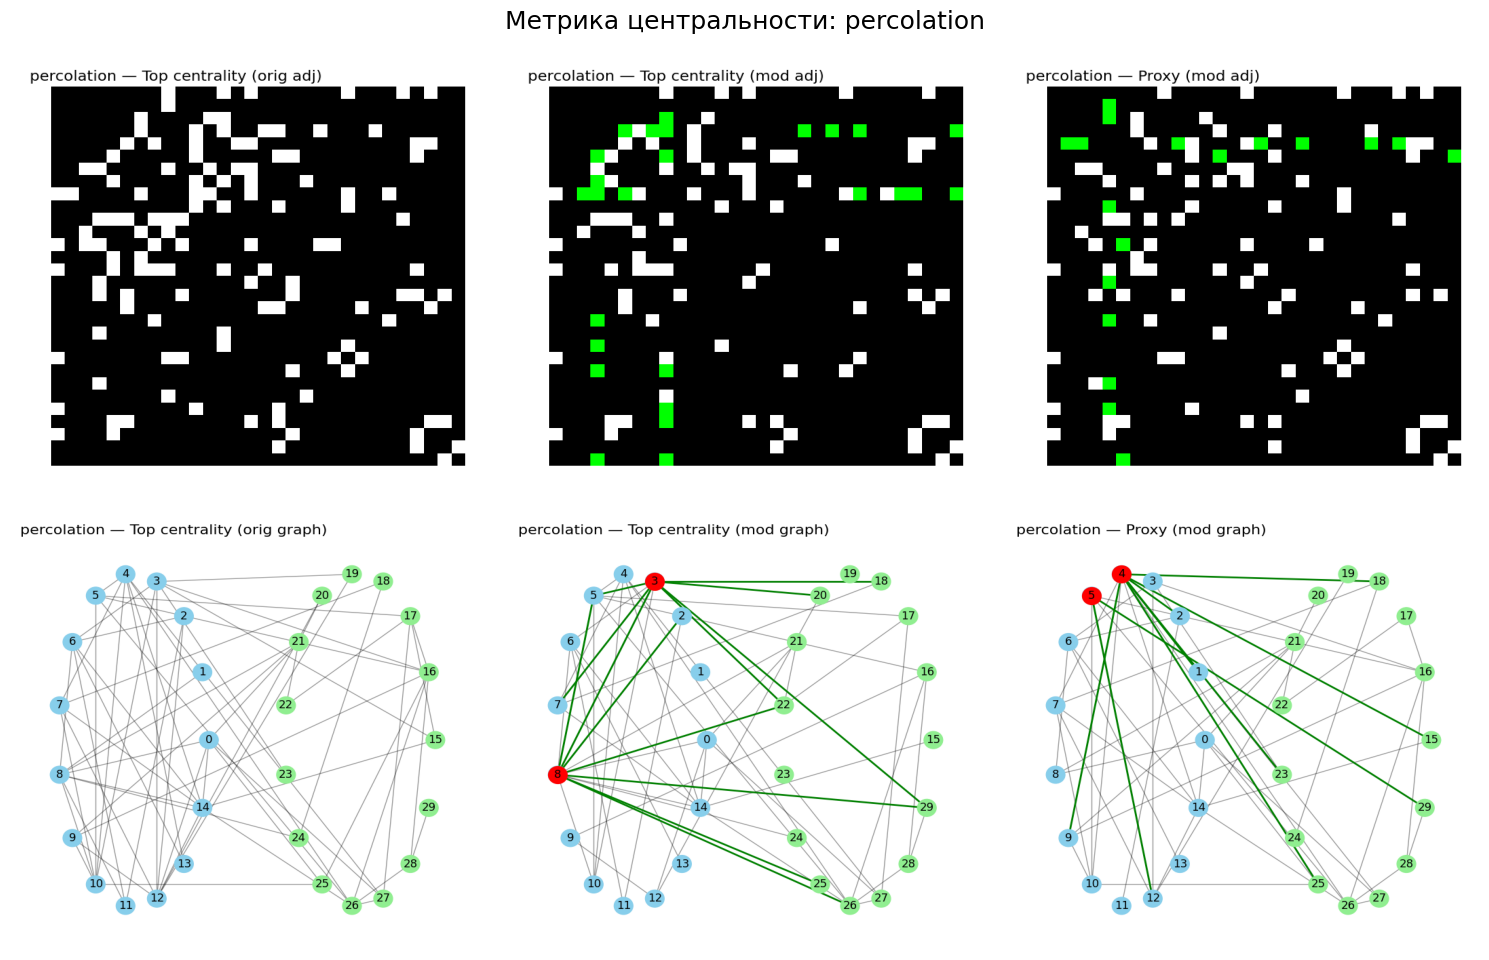

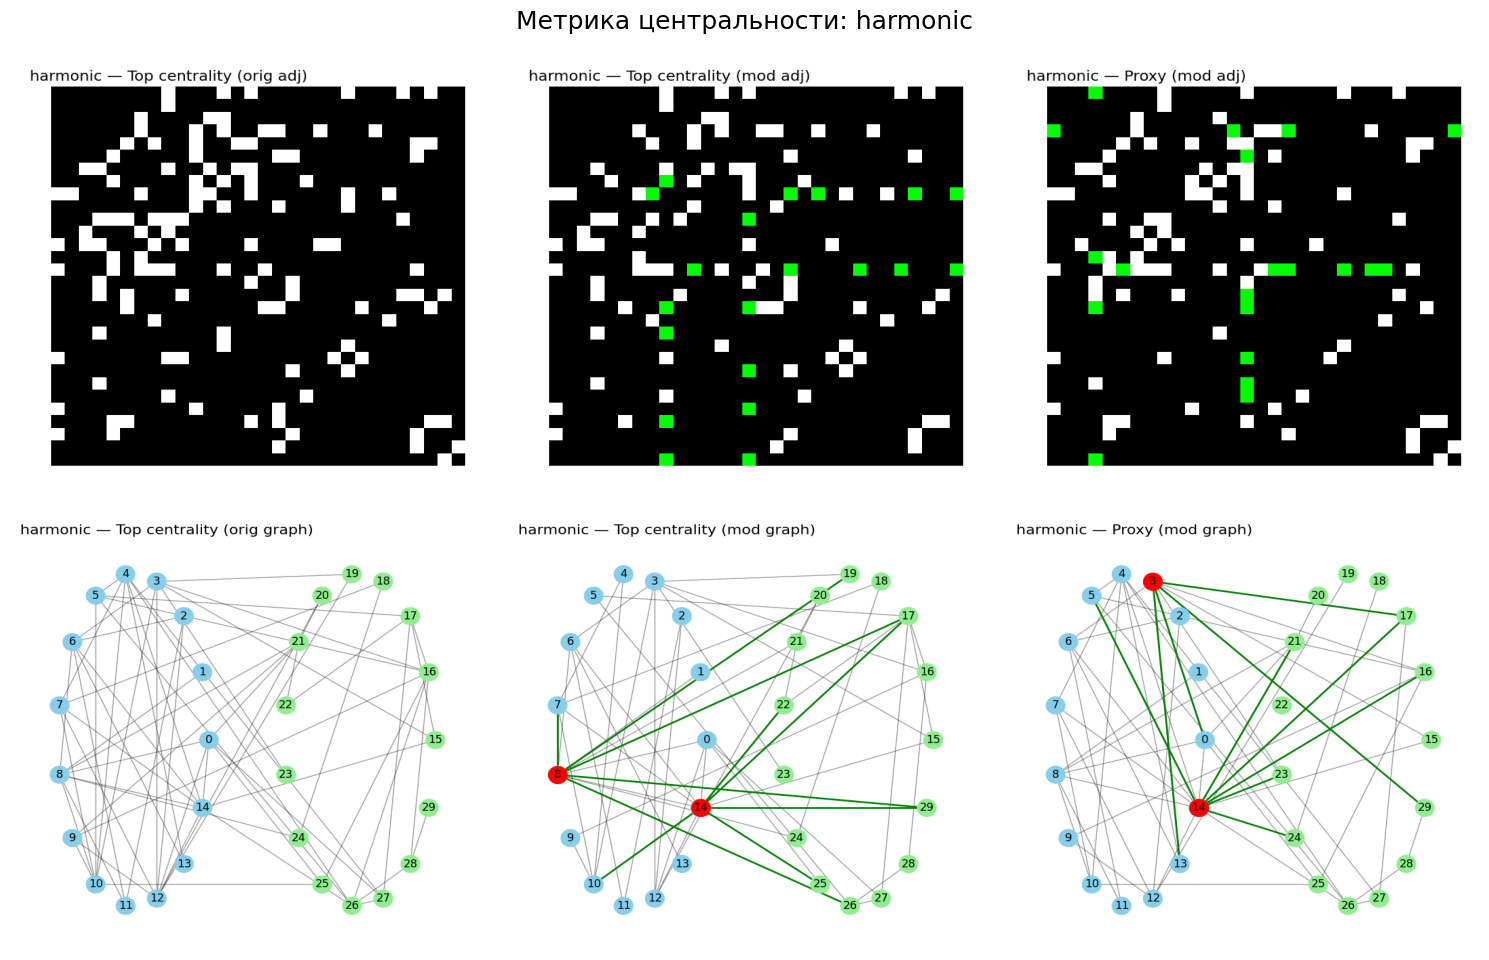

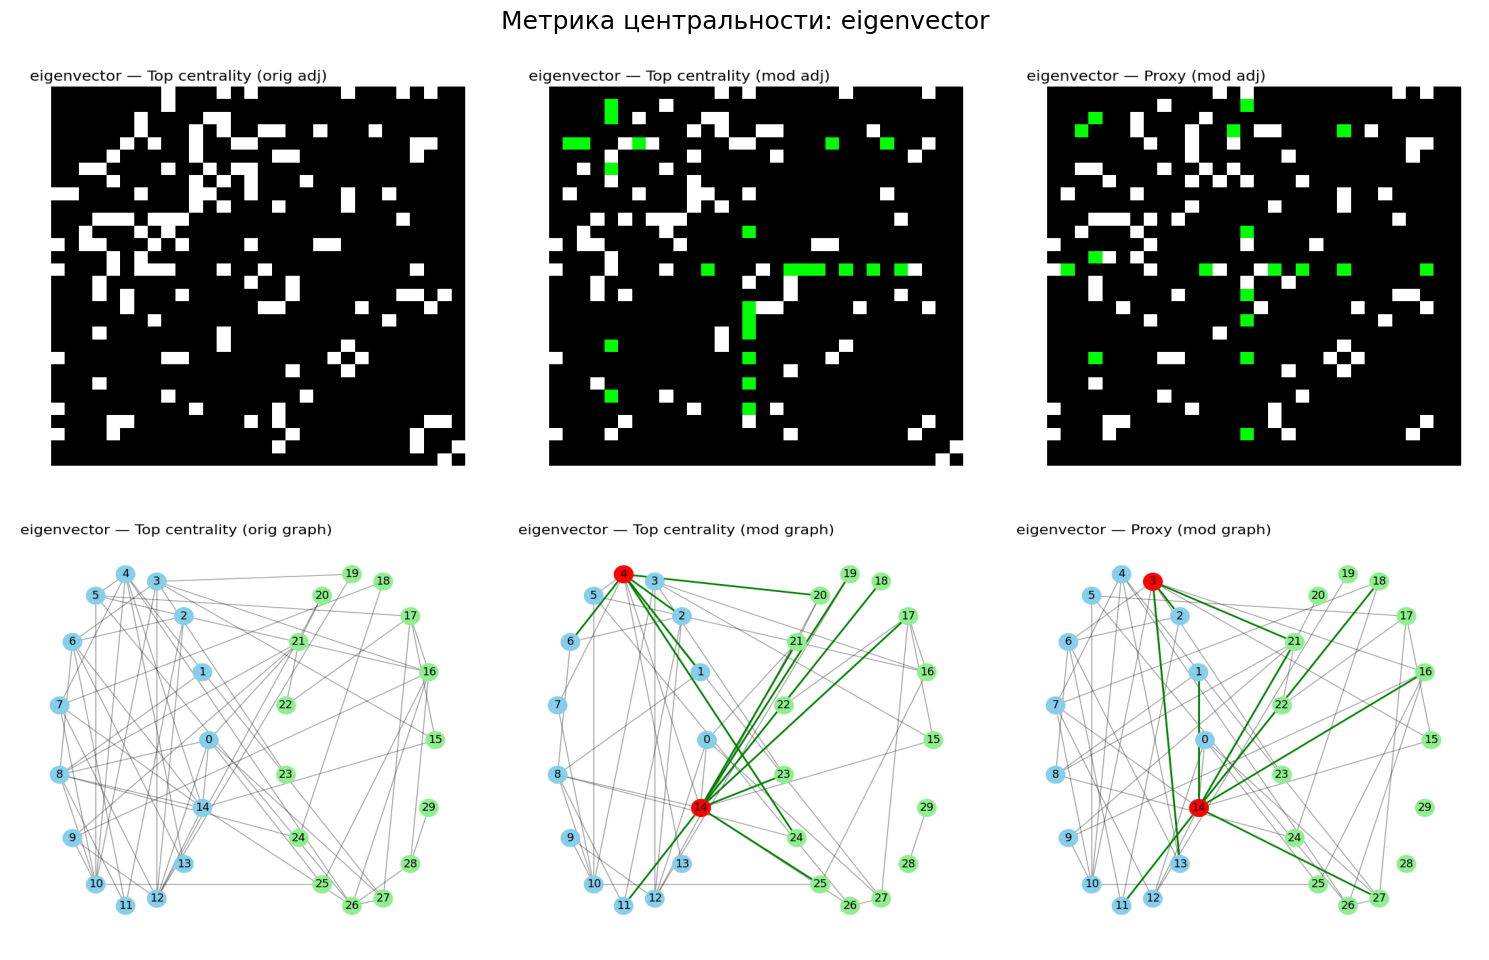

In [4]:
import os
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from typing import List, Tuple

# --- параметры эксперимента (те же, что у вас) ---
centralities = [
    'betweenness', 'closeness', 'degree',
    'percolation', 'harmonic', 'eigenvector'
]
modes = [
    ("Original",        "one_cluster_s_boost"),      # для оригинального сети
    ("Top centrality",  "one_cluster_s_boost"),
    ("Proxy",           "random_neighbors_s_boost"),
]
results_dir = "sbm_arb/results"

# убедимся, что директория с картинками существует
if not os.path.isdir(results_dir):
    raise FileNotFoundError(f"Каталог {results_dir} не найден")

for cent in centralities:
    # создаём фигуру 2×4
    fig, axes = plt.subplots(
        2, 3, figsize=(15, 10),
        gridspec_kw={'wspace':0.05, 'hspace':0.05}
    )
    fig.suptitle(f"Метрика центральности: {cent}", fontsize=18, y=0.95)

    for col, (label, mode) in enumerate(modes):
        # выбираем имя файлов
        if col == 0:
            # оригинальная сеть: используем orig-версию из первого режима
            adj_fname   = f"adj_{cent}_one_cluster_s_boost_orig.png"
            graph_fname = f"graph_{cent}_one_cluster_s_boost_orig.png"
        else:
            adj_fname   = f"adj_{cent}_{mode}_mod.png"
            graph_fname = f"graph_{cent}_{mode}_mod.png"

        adj_path   = os.path.join(results_dir, adj_fname)
        graph_path = os.path.join(results_dir, graph_fname)

        # проверяем наличие
        if not os.path.isfile(adj_path):
            raise FileNotFoundError(f"Не найден файл матрицы: {adj_path}")
        if not os.path.isfile(graph_path):
            raise FileNotFoundError(f"Не найден файл графа: {graph_path}")

        # верхний ряд: матрица
        ax_adj = axes[0, col]
        img_adj = mpimg.imread(adj_path)
        ax_adj.imshow(img_adj, aspect='auto')
        ax_adj.axis('off')

        # нижний ряд: граф
        ax_graph = axes[1, col]
        img_graph = mpimg.imread(graph_path)
        ax_graph.imshow(img_graph, aspect='auto')
        ax_graph.axis('off')

    # убрать поля вокруг
    plt.subplots_adjust(
        left=0.01, right=0.99,
        top=0.90, bottom=0.01,
        wspace=0.02, hspace=0.02
    )
    plt.savefig(f'sbm_arb/results/combined_3_plots_{cent}.png', 
                   bbox_inches='tight', 
                   pad_inches=0.02, 
                   dpi=300)
    plt.show()
